CoNLL-2003 (https://www.clips.uantwerpen.be/conll2003/ner/) is a well-known data set for named entity recognition (NER) task, which provides the part-of-speech (POS) tag, chunking tag (for phrase) and name entity tag for every word in one line. The end of sentence corresponds to an empty line in the file.

In terms of the name entity tags, the data highlights those for **organization** (**I-ORG**), **person** (**I-PER**) and **location** (**I-LOC**), and marks the rest names as **miscellaneous** (**I-MISC**). Null label **O** is assigned to words that are not (part of) a name. 

Besides, there are certain situations that two phrases of the same type immediately follow each other, the first word of the second phrase is **B**-initialized instead to distinguish. For instance, "...Golan (I-LOC) Heights (I-LOC) Israel (**B-LOC**)...".

In [60]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Input, Model
from keras.layers import Embedding, Dense, Bidirectional, LSTM, TimeDistributed, Dropout

pd.options.display.max_rows = 30

### Data preprocessing

#### Read in the training data, index the sentences, and remove the prefix (I and B) of entity tags.

In [35]:
train = pd.read_csv("./data/CoNLL-2003/eng.train", names=["word", "POS", "chunk", "origin_entity"], 
                    header=None, sep=" ", skip_blank_lines=False)

In [36]:
# drop prefix of name entity tag
train["entity"] = train["origin_entity"].str.rsplit("-", 1).str[-1]

In [37]:
# add sentence number
train["sentence"] = train.isnull().all(axis=1).cumsum()

In [38]:
# no longer needs the empty rows after indexing the sentences
train = train.dropna()

#### Encode the name entity tags and words (one-hot for tags).

In [99]:
entity_tag_encoder = LabelEncoder()
train['y'] = entity_tag_encoder.fit_transform(train.entity)

(array([  6.96900000e+03,   3.09300000e+03,   1.72900000e+03,
          1.47000000e+03,   1.16400000e+03,   4.29000000e+02,
          1.09000000e+02,   1.70000000e+01,   2.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00]),
 array([   1.        ,    8.46666667,   15.93333333,   23.4       ,
          30.86666667,   38.33333333,   45.8       ,   53.26666667,
          60.73333333,   68.2       ,   75.66666667,   83.13333333,
          90.6       ,   98.06666667,  105.53333333,  113.        ]),
 <a list of 15 Patch objects>)

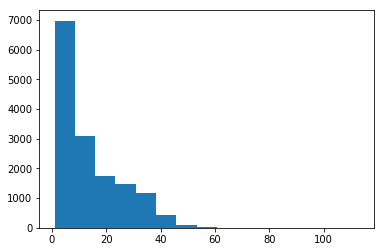

In [40]:
# take a look at the length distribution of sentences, most of which falls below 60
plt.hist(train.groupby('sentence').agg('count')['word'], bins=15)

In [41]:
word_encoder = LabelEncoder()
train['x'] = word_encoder.fit_transform(train.word)

In [65]:
onehot_encoder = LabelBinarizer()
onehot_encoder.fit(train.y)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [67]:
x_train_sentence = train.groupby('sentence')['x'].apply(list)
y_train_tag = train.groupby('sentence')['y'].apply(list)
y_train_tag_onehot = [onehot_encoder.transform(group) for group in y_train_tag]

#### Pad (encoded) sentences and tags to the unifed length 60. (accuracy upper bound ~ .7842)
* Increasing length to 100 shifts the accuracy

In [87]:
x_train_seq = pad_sequences(x_train_sentence, maxlen=100, value=-1)
y_train_seq = pad_sequences(y_train_tag_onehot, maxlen=100, value=0)

#### Word embedding with 50 dimensional GloVe pretrained word vectors.

In [12]:
GloVe = pd.read_table('data/glove.6B.50d.txt', index_col=0, header=None, sep=' ', quoting=csv.QUOTE_NONE)

In [88]:
# 
embedding_matrix = np.zeros((len(word_encoder.classes_) + 1, 50))
for i, word in enumerate(word_encoder.classes_):
    try:
        embedding_matrix[i] = GloVe.loc[word]
    except:
        pass

### Model setting

In [89]:
input_ = Input(shape=(100,))
x_ = Embedding(*embedding_matrix.shape, weights=[embedding_matrix])(input_)
x_ = Bidirectional(LSTM(275, return_sequences=True))(x_)
x_ = TimeDistributed(Dense(5, activation='softmax'))(x_)
x_ = Dropout(0.5)(x_)
model = Model(inputs=input_, outputs=x_)
model.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
print model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 100)               0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 100, 50)           1181150   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 100, 550)          717200    
_________________________________________________________________
time_distributed_13 (TimeDis (None, 100, 5)            2755      
_________________________________________________________________
dropout_13 (Dropout)         (None, 100, 5)            0         
Total params: 1,901,105
Trainable params: 1,901,105
Non-trainable params: 0
_________________________________________________________________
None


In [90]:
model.fit(x_train_seq, y_train_seq, epochs=5, batch_size=128)

Epoch 1/5
14984/14984 [==============================] - 37s 2ms/step - loss: 0.0097 - acc: 0.8650
Epoch 2/5
14984/14984 [==============================] - 37s 2ms/step - loss: 1.6100e-08 - acc: 0.8705
Epoch 3/5
14984/14984 [==============================] - 37s 2ms/step - loss: 1.6100e-08 - acc: 0.8705
Epoch 4/5
14984/14984 [==============================] - 39s 3ms/step - loss: 1.6100e-08 - acc: 0.8705
Epoch 5/5
14984/14984 [==============================] - 38s 3ms/step - loss: 1.6100e-08 - acc: 0.8705


#### Read and encode test data and encode

In [93]:
test = pd.read_csv('data/CoNLL-2003/eng.testa', names=["word", "POS", "chunk", "origin_entity"], 
                    header=None, sep=" ", skip_blank_lines=False)

In [94]:
# drop prefix of name entity tag
test["entity"] = test["origin_entity"].str.rsplit("-", 1).str[-1]

In [95]:
# add sentence number
test["sentence"] = test.isnull().all(axis=1).cumsum()

In [96]:
# no longer needs the empty rows after indexing the sentences
test = test.dropna()

In [100]:
test['y'] = entity_tag_encoder.transform(test.entity)

Requires a little workaround to solve the out-of-bag words encoding for `fit` method of `LabelEncoder`

In [111]:
word_map = {word: idx for idx, word in enumerate(word_encoder.classes_)}
test['x'] = test['word'].apply(lambda x: word_map.get(x, len(word_encoder.classes_)))

In [112]:
test.x

0         5313
1          111
2        23622
3        12467
4        10252
5         3924
6        12519
7         3850
8         7933
9        13045
10         123
12        8816
13        1407
15       13380
16        8029
         ...  
55025    23622
55026    19476
55027    13689
55028    22909
55029    19431
55030    23622
55031    18975
55032    22423
55033    19476
55034    12736
55035      123
55037      112
55038     6189
55039    10058
55040    23622
Name: x, Length: 50934, dtype: int64